In [ ]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import TimeSeriesTensor, mape, extract_data, create_evaluation_df
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
!git clone https://github.com/Arghyam-Team/KRSPrediction.git

Cloning into 'KRSPrediction'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 209 (delta 84), reused 114 (delta 33), pack-reused 0
Receiving objects: 100% (209/209), 3.55 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
import sqlite3
db_file = '/content/KRSPrediction/data/pythonsqlite.db'
conn = sqlite3.connect(db_file)
cur = conn.cursor()
sql = "SELECT water.date, water.storage_tmc, water.inflow_cusecs, water.outflow_cusecs, weather.max_temp, weather.visibility, weather.wind, weather.humidity, weather.cloudcover FROM water INNER JOIN weather ON  water.reservoir='krs' AND weather.location='karnataka' AND water.date = weather.date"
cur.execute(sql)
rows = cur.fetchall() # rows is a list of tuples (date, tmc,inflow,outflow,maxtemp,vis,wind,hum,cloud)

In [ ]:
krs = pd.DataFrame(rows, columns=['date', 'present_storage_tmc', 'inflow', 'outflow', 'max_temp', 'visibility', 'wind', 'humidity', 'cloudcover'])

In [ ]:
krs.head(2)

,date,present_storage_tmc,inflow,outflow,max_temp,visibility,wind,humidity,cloudcover
0,2011-01-01,46.42,2029,2000.0,28.1,6.7,11.2,71.39,36.7
1,2011-01-02,46.54,3084,1490.0,28.0,6.2,10.3,72.90,51.4


In [ ]:
krs = krs.drop_duplicates(subset=["date"])

In [ ]:
krs.date = pd.to_datetime(krs.date)
krs['inflow'] = pd.to_numeric(krs.inflow, errors='coerce')

In [ ]:
krs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3531 non-null   datetime64[ns]
 1   present_storage_tmc  3531 non-null   float64       
 2   inflow               3530 non-null   float64       
 3   outflow              3531 non-null   float64       
 4   max_temp             3531 non-null   float64       
 5   visibility           3531 non-null   float64       
 6   wind                 3531 non-null   float64       
 7   humidity             3531 non-null   float64       
 8   cloudcover           3531 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 275.9 KB


In [ ]:
krs['inflow_tmc'] = krs['inflow'] /11000
krs['outflow_tmc'] = krs['outflow'] / 11000

In [ ]:
krs.sort_values(by=['date'], inplace=True, ascending=True)

In [ ]:
krs.set_index('date', inplace=True)
krs = krs.sort_index(axis=1)

In [ ]:
krs.head(2)

,cloudcover,humidity,inflow,inflow_tmc,max_temp,outflow,outflow_tmc,present_storage_tmc,visibility,wind
date,,,,,,,,,,
2010-09-30,79.6,81.05,2706.0,0.246000,29.4,6840.0,0.621818,46.18,5.2,11.2
2010-12-31,51.0,70.80,2668.0,0.242545,27.5,6795.0,0.617727,45.81,6.9,11.2


In [ ]:
#time series data on which model needs to be trained on, features contain the column names
ts_data_load = krs[[ "present_storage_tmc", "inflow_tmc", "outflow_tmc", "max_temp", "visibility", "humidity", "wind"]]
ts_data_load.sort_index(axis = 1)
features = len(ts_data_load.columns)
#features, ts_data_load.head(2), ts_data_load.tail(2)

In [ ]:
valid_st_data_load = "2018-01-01 00:00:00"
test_st_data_load = "2019-05-02 00:00:00"

In [ ]:
ts_data_load[ts_data_load.index==valid_st_data_load]

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-01-01,25.55,0.026455,0.313182,28.0,6.6,65.5,11.0


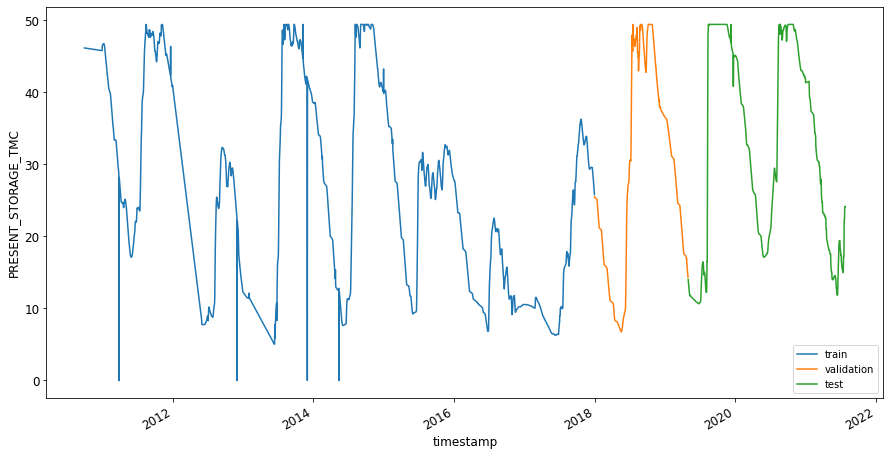

In [ ]:
ts_data_load[ts_data_load.index < valid_st_data_load][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["present_storage_tmc"]
    ].rename(columns={"present_storage_tmc": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()

In [ ]:
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load]

In [ ]:
train.shape

(2250, 7)

In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["present_storage_tmc"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
flist = list(ts_data_load.columns)

In [ ]:
T = 60
HORIZON = 30
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][flist]

X_scaler = MinMaxScaler()
train[flist] = X_scaler.fit_transform(train)
train.sample(10)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2011-09-04,0.984429,0.405622,0.372438,0.462617,0.750000,0.647774,0.158578
2016-05-11,0.212942,0.001184,0.003083,0.649533,0.800000,0.381224,0.062884
2012-09-04,0.564004,0.148867,0.050753,0.369159,0.583333,0.684388,0.177033
2017-02-21,0.204044,0.001100,0.002454,0.654206,0.616667,0.230375,0.038961
2017-12-28,0.546411,0.003824,0.045784,0.275701,0.400000,0.536467,0.114833
2011-03-13,0.674419,0.010656,0.014846,0.570093,0.800000,0.326303,0.089542
2013-11-07,0.909201,0.013558,0.037256,0.509346,0.583333,0.547891,0.051948
2016-07-30,0.450556,0.062206,0.085454,0.317757,0.650000,0.859988,0.127136
2017-04-24,0.163802,0.004034,0.008934,0.775701,0.800000,0.247364,0.070403


In [ ]:
train = train.dropna(axis = 0, how ='any')
train.isna().sum()

present_storage_tmc    0
inflow_tmc             0
outflow_tmc            0
max_temp               0
visibility             0
humidity               0
wind                   0
dtype: int64

In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}
print(tensor_structure)
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    days=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= back_ts_data) & (ts_data_load.index < test_st_data_load)][
    flist
]
valid[flist] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "present_storage_tmc", HORIZON, tensor_structure, freq='D')

{'X': (range(-59, 1), ['present_storage_tmc', 'inflow_tmc', 'outflow_tmc', 'max_temp', 'visibility', 'humidity', 'wind'])}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
LATENT_DIM = T
BATCH_SIZE = 32
EPOCHS = (
    100
)

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, return_sequences=True,input_shape=(T, features)))
#model.add(GRU(LATENT_DIM, input_shape=(T, 3)))
model.add(GRU(LATENT_DIM))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer="adam", loss="mse")


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 60)            12420     
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
Total params: 36,210
Trainable params: 36,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/100
54/54 [==============================] - 7s 71ms/step - loss: 0.0896 - val_loss: 0.0171
Epoch 2/100
54/54 [==============================] - 3s 59ms/step - loss: 0.0086 - val_loss: 0.0121
Epoch 3/100
54/54 [==============================] - 3s 59ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 4/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0061 - val_loss: 0.0118
Epoch 5/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0057 - val_loss: 0.0113
Epoch 6/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0056 - val_loss: 0.0109
Epoch 7/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0059 - val_loss: 0.0125
Epoch 8/100
54/54 [==============================] - 3s 59ms/step - loss: 0.0056 - val_loss: 0.0102
Epoch 9/100
54/54 [==============================] - 3s 59ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 10/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0053 - val_loss: 0.0101

In [ ]:
model.save("60daysto30days")

INFO:tensorflow:Assets written to: 60daysto30days/assets


INFO:tensorflow:Assets written to: 60daysto30days/assets


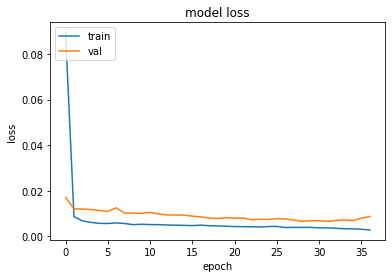

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

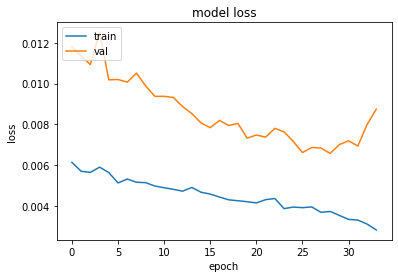

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'][3:])
plt.plot(model_history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ts_data_test = ts_data_load.copy()[test_st_data_load:][flist]
ts_data_test[flist] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "present_storage_tmc", HORIZON, tensor_structure, freq='D')


In [ ]:
ts_data_test_inputs['X'].shape

(514, 60, 7)

In [ ]:
def create_evaluation_df1(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    
    eval_df["timestamp"] = test_inputs.dataframe.index
    print(eval_df.shape, eval_df.head(2))

    #eval_df = pd.melt(
    #    eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    #)
    values = ['t+'+str(i) for i in range(1, H+1)]
    
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_vars=values, value_name="prediction"
    )
    print(eval_df.shape, eval_df.head(2))
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

In [ ]:
ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df1(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.sample(5)

(514, 31)        t+1       t+2       t+3  ...      t+29      t+30  timestamp
0  0.22503  0.229032  0.248271  ...  0.516949  0.511683 2019-06-30
1  0.22596  0.227548  0.251563  ...  0.518884  0.516496 2019-07-01

[2 rows x 31 columns]
(15420, 3)    timestamp variable  prediction
0 2019-06-30      t+1     0.22503
1 2019-07-01      t+1     0.22596


,timestamp,variable,prediction,actual
13694,2020-12-25,t+27,38.228844,39.512000
8273,2019-08-18,t+17,52.523318,49.450000
9637,2021-02-18,t+19,30.827930,30.454000
14999,2019-10-01,t+30,50.019707,49.450000
8150,2021-04-14,t+16,20.880691,18.398091


In [ ]:
ts_predictions.shape

(514, 30)

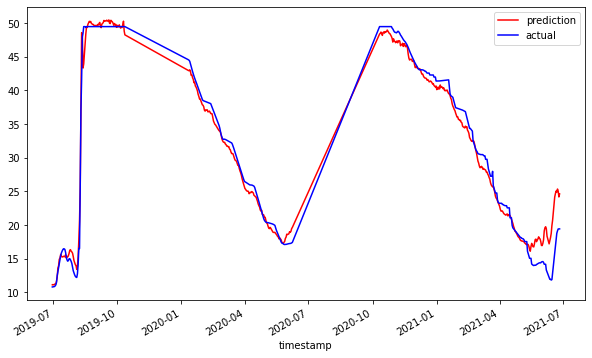

In [ ]:
ev_ts_data[ev_ts_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:

mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.19011912750518378

In [ ]:
ev_ts_data.to_csv("forecast_withdatecolumns.csv")

In [ ]:
import datetime
forecast_dates = ev_ts_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_ts_data["date"] = forecast_dates


In [ ]:
ev_ts_data.head(2)

,timestamp,variable,prediction,actual,date
0,2019-06-30,t+1,11.127720,10.81,2019-07-01
1,2019-07-01,t+1,11.173743,10.83,2019-07-02


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#finetuning
T = 60
HORIZON = 30
ftrain = ts_data_load.copy()[flist]

X_scaler = MinMaxScaler()
ftrain[flist] = X_scaler.fit_transform(ftrain)
ftrain.sample(2)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2016-06-29,0.139737,0.010411,0.009639,0.266355,0.147619,0.904444,0.118081
2021-06-16,0.240728,0.005965,0.002332,0.415888,0.147619,0.797813,0.167633


In [ ]:
ftrain.last('1D')

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2021-07-26,0.488493,0.053957,0.015142,0.35514,1.0,0.650149,0.129151


In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}

ts_train_inp = TimeSeriesTensor(
    dataset=ftrain,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
#back_ts_data = dt.datetime.strptime(date.today(), "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    days=T - 1
#)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=20,
    #validation_data=(valid_inputs["X"], valid_inputs["target"]),
    #callbacks=[earlystop],
    verbose=1,
)

Epoch 1/20
88/88 [==============================] - 5s 57ms/step - loss: 0.0114
Epoch 2/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0067
Epoch 3/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0064
Epoch 4/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0061
Epoch 5/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0060
Epoch 6/20
88/88 [==============================] - 5s 56ms/step - loss: 0.0058
Epoch 7/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0058
Epoch 8/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0058
Epoch 9/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0055
Epoch 10/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0053
Epoch 11/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0052
Epoch 12/20
88/88 [==============================] - 5s 55ms/step - loss: 0.0050
Epoch 13/20
88/88 [==================

In [ ]:
ts_predictions = model.predict(ts_train_inp["X"])

ev_all_data = create_evaluation_df1(ts_predictions, ts_train_inp, HORIZON, y_scaler)
ev_all_data.sample(5)

(2803, 31)         t+1       t+2       t+3  ...      t+29      t+30  timestamp
0  0.720165  0.716646  0.712394  ...  0.604702  0.608660 2011-02-28
1  0.711362  0.711029  0.704198  ...  0.593289  0.595563 2011-03-01

[2 rows x 31 columns]
(84090, 3)    timestamp variable  prediction
0 2011-02-28      t+1    0.720165
1 2011-03-01      t+1    0.711362


,timestamp,variable,prediction,actual
63162,2017-04-28,t+23,6.730829,6.63
7973,2019-09-16,t+3,49.453419,49.45
46222,2016-12-27,t+17,9.172245,10.53
73944,2016-02-23,t+27,13.881004,12.77
31009,2011-08-23,t+12,47.250967,48.68


In [ ]:
model.save("60daysto30days")

INFO:tensorflow:Assets written to: 60daysto30days/assets


INFO:tensorflow:Assets written to: 60daysto30days/assets


In [ ]:
cp -r '/content/60daysto30days/' '/content/gdrive/My Drive/Wave2web/'

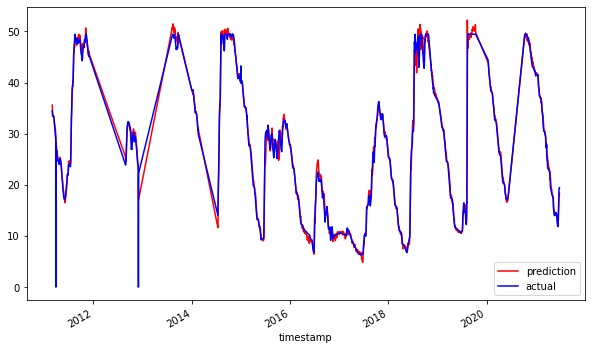

In [ ]:
ev_all_data[ev_all_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:
import datetime
forecast_dates = ev_all_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_all_data["date"] = forecast_dates


In [ ]:
ev_all_data.sample(20)

,timestamp,variable,prediction,actual,date
72708,2021-01-08,t+26,37.763987,37.237,2021-02-03
42547,2014-08-08,t+16,50.640675,48.250,2014-08-24
74546,2017-10-17,t+27,31.257775,33.310,2017-11-13
14896,2015-08-22,t+6,29.769914,26.920,2015-08-28
50776,2012-10-07,t+19,27.683343,30.070,2012-10-26
22522,2011-06-06,t+9,18.153354,19.830,2011-06-15
36484,2011-04-14,t+14,21.806799,25.040,2011-04-28
46172,2016-11-07,t+17,9.020504,9.910,2016-11-24
71319,2016-08-19,t+26,15.588709,14.640,2016-09-14
11951,2015-04-02,t+5,19.603572,19.720,2015-04-07


In [ ]:
ev_all_data.to_csv("predictions.csv")

In [ ]:
import sqlite3


In [ ]:
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [ ]:
df = pd.read_csv("predictions.csv")

In [ ]:
df.head()

,Unnamed: 0,timestamp,variable,prediction,actual,date
0,0,2011-01-29,t+1,41.820400,41.79,2011-01-30
1,1,2011-01-30,t+1,41.589464,41.56,2011-01-31
2,2,2011-01-31,t+1,41.276625,41.30,2011-02-01
3,3,2011-02-01,t+1,41.035273,40.98,2011-02-02
4,4,2011-02-02,t+1,40.736331,40.66,2011-02-03


In [ ]:
c.execute("CREATE TABLE PREDICTIONS ([timestamp] integer, [prediction] integer, [actual] integer, [date] integer)")

In [ ]:
conn.commit()

In [ ]:
conn = sqlite3.connect('predictions.db')  
c = conn.cursor()

In [ ]:
df[['timestamp', 'prediction', 'actual', 'date']].to_sql('PREDICTIONS', conn, if_exists='append', index = False)